# Apply CWT to the FHR signals according to Daydulo et al. 2022

[Daydulo et al. 2022](https://doi.org/10.1186/s12911-022-02068-1) - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study.

Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. The Creative Commons Public Domain Dedication waiver (http://creativecommons.org/publicdomain/zero/1.0/) applies to the data made available in this article, unless otherwise stated in a credit line to the data. Reprints and Permissions

## Set up

In [1]:
from dataclasses import dataclass
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import imshow

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'
    first = './outputs/daydulo_cwt_first_stage'
    second = './outputs/daydulo_cwt_second_stage'
    train = 'train'
    test = 'test'
    normal = 'class_0_normal'
    distress = 'class_1_distressed'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

# Load meta data and transform
metadata = pd.read_csv('./data_csv/metadata.csv', index_col='parameter')
csv_index = list(metadata)

## Seperate by class (normal or distressed/pathological)

### Method description from Daydulo et al. 2022

**Threshold:** pH <= 7.15 as pathological and pH > 7.15 as normal. This created:
* 439 normal - or 878 inc. 1st + 2nd stage
* 113 pathologic/distressed - or 226 inc. 1st + 2nd stage

### Perform classification

Create column with class for each record based on pH.

In [4]:
ph = metadata[metadata.index == 'pH'].T
ph['class'] = np.where(ph['pH'] <= 7.15, 1, 0)
ph['class'].value_counts()

class
0    439
1    113
Name: count, dtype: int64

Seperate dictionary of signals into normal or distressed.

In [5]:
# Get list of ID in distressed class
distress_records = ph[ph['class'] == 1].index.tolist()
print(f'Preview records{distress_records[0:5]}')

# Filter dictionary to those ID, and double-check length is correct
csv_distress = dict((k, csv_files[k]) for k in distress_records)

# Double-check its the correct length
print(f'Checking dictionary length: {len(csv_distress)}')

Preview records['1347', '1358', '1108', '1036', '1219']
Checking dictionary length: 113


In [6]:
# Get list of ID in normal class
normal_records = ph[ph['class'] == 0].index.tolist()
print(f'Preview records{normal_records[0:5]}')

# Filter dictionary to those ID, and double-check length is correct
csv_normal = dict((k, csv_files[k]) for k in normal_records)

# Double-check its the correct length
print(f'Checking dictionary length: {len(csv_normal)}')

Preview records['2040', '1054', '1247', '1127', '1231']
Checking dictionary length: 439


## Signal pre-processing

### Method from Daydulo et al. 2022

Signal pre-processing:
* Long gaps (more than 15s) removed from the signal
* Missing values at beginning and end of recording excluded to start from the stable point
* Outside 50bpm or 200bpm are outliers
* Outliers and small gaps were find and linearly interpolated using Matlab
* Spikes are when beat is more than 25 from previous adjacent beat (not physiologic, unreliable) so removed using cubic spline interpolation.

Selected segment of the first 20 minutes (4800) and last 15 minutes (3600) to use and represent first and second stage of labour.

### Clean the normal and distressed signals

In [7]:
def daydulo_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Daydulo et al. 2022
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

In [8]:
def clean_signals(sig_dict):
    '''
    Cleans signals in provided dictionary, and returns two (one representing
    first stage and one representing second stage)
    Inputs:
    - sig_dict - dictionary of dataframes which have FHR column for cleaning
    Outputs:
    - fhr_first - dictionary of clean FHR signals for first stage of labour
    - fhr_second - dictionary of clean FHR signals for second stage of labour
    '''
    fhr_first = dict()
    fhr_second = dict()
    for key, value in sig_dict.items():
        df = daydulo_clean(value.FHR)
        fhr_first[key] = df.head(4800)
        fhr_second[key] = df.tail(3600).reset_index(drop=True)

    return(fhr_first, fhr_second)

In [9]:
# Apply cleaning to the signals
fhr_normal_first, fhr_normal_second = clean_signals(csv_normal)
fhr_distress_first, fhr_distress_second = clean_signals(csv_distress)

Plot example from Daydulo et al. 2022 -

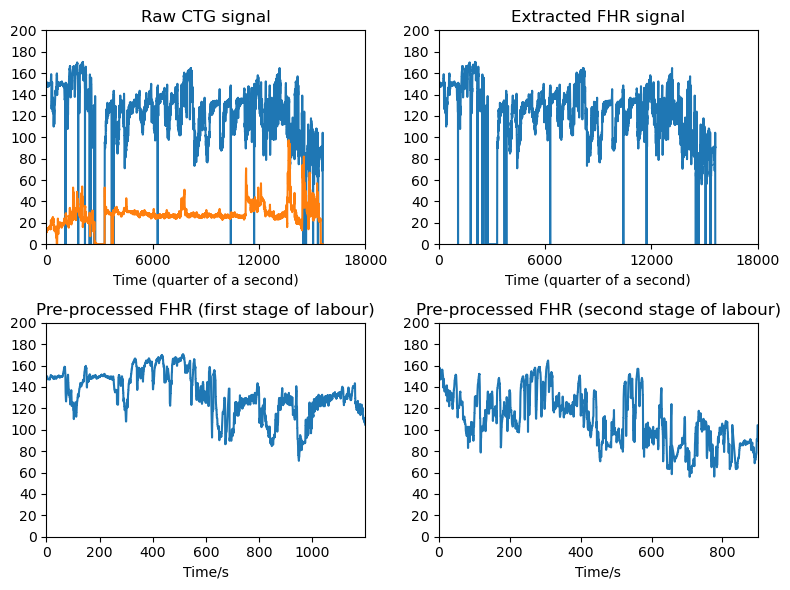

In [10]:
# Initialise plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

# Plot raw FHR and UC
ax[0,0].plot(csv_files['1011'].FHR.fillna(0))
ax[0,0].plot(csv_files['1011'].UC.fillna(0))
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time (quarter of a second)')
ax[0,0].set_title('Raw CTG signal')
ax[0,0].set_xticks([0, 6000, 12000, 18000])
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot raw FHR
ax[0,1].plot(csv_files['1011'].FHR.fillna(0))
ax[0,1].margins(x=0)
ax[0,1].set_ylim(0, 200)
ax[0,1].set_xlabel('Time (quarter of a second)')
ax[0,1].set_title('Extracted FHR signal')
ax[0,1].set_xticks([0, 6000, 12000, 18000])
ax[0,1].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 1
ax[1,0].plot(fhr_normal_first['1011'].index/4, fhr_normal_first['1011'])
ax[1,0].margins(x=0)
ax[1,0].set_ylim(0, 200)
ax[1,0].set_xlabel('Time/s')
ax[1,0].set_title('Pre-processed FHR (first stage of labour)')
ax[1,0].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 2
ax[1,1].plot(fhr_normal_second['1011'].index/4, fhr_normal_second['1011'])
ax[1,1].margins(x=0)
ax[1,1].set_ylim(0, 200)
ax[1,1].set_xlabel('Time/s')
ax[1,1].set_title('Pre-processed FHR (second stage of labour)')
ax[1,1].set_yticks(np.arange(0, 201, 20))

plt.tight_layout()
plt.show()

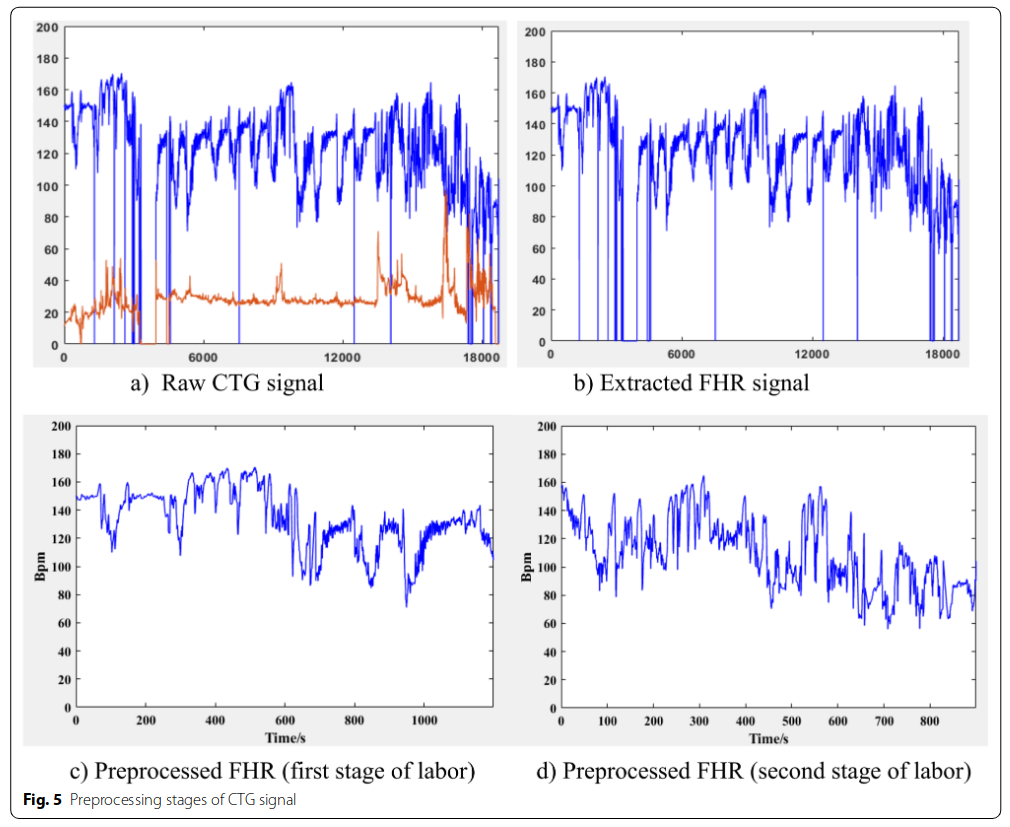

In [11]:
Image('images/daydulo_figure5.png')

## Data augmentation

### Description of method used by Daydulo et al. 2022

**Threshold:** pH <= 7.15 as pathological and pH > 7.15 as normal. This created:
* 439 normal - or 878 inc. 1st + 2nd stage
* 113 pathologic/distressed - or 226 inc. 1st + 2nd stage

**Slicing augmentation:** augment data by removing or adding time steps to pattern ends.
* Oversample the minority class by slicing shifting backward for five minute two times. Therefore, slice of 20-min window slide for first stage and 15-min window slice for second labor stage were generated.
* After augmentation final dataset contained 1556 time frequency images of which:
    * 878 for normal class inc. 1st + 2nd stage
    * 678 for pathologic/distressed class. inc. 1st + 2nd stage - *so three times as many records (226x3=678)*

Augmentation of the distressed class will mean we have 3 versions of each segment - the original version, and then two slices.

Window slicing involves shifting the window of data that you extract, which they do by five minutes two times.

I'm therefore assuming this to mean that we have something like this (these numbers if it's a full 90m record):
* First stage normal (0-20m)
* First stage shift one (5-25m)
* First stage shift two (10-30m)
* Second stage normal (70-90m)
* Second stage shift one (65-85m)
* Second stage shift two (60-80m)

### Perform slicing augmentation

Calculate what extracts are required for slicing augmentation

In [12]:
print(f'''
20 minutes is {4*60*20}, 5 minutes is {4*60*5}

First stage:
[0:4800] to get first 4800 items, so would
then be [1200:{4800+1200}], [2400:{4800+2400}]

Second stage:
Last 20 minutes is [-3600:], so would
then be [-{3600+1200}:-1200] and [-{3600+2400}:-2400]''')


20 minutes is 4800, 5 minutes is 1200

First stage:
[0:4800] to get first 4800 items, so would
then be [1200:6000], [2400:7200]

Second stage:
Last 20 minutes is [-3600:], so would
then be [-4800:-1200] and [-6000:-2400]


Perform augmentation on distressed records

In [13]:
# Loop through those files, clean, and append the slices to the right dictionary
# With key name modified as _5 or _10 depending on the slice
# Have to use raw data as we clipped when saving to e.g. fhr_distress_first
for key, value in csv_distress.items():
    df = daydulo_clean(value.FHR)
    fhr_distress_first[f'{key}_5'] = df[1200:6000]
    fhr_distress_first[f'{key}_10'] = df[2400:7200]
    fhr_distress_second[f'{key}_5'] = df[-4800:-1200]
    fhr_distress_second[f'{key}_10'] = df[-6000:-2400]

Check total number of records after augmentation.

In [14]:
print(f'''Total normal signals: {
    len(fhr_normal_first) + len(fhr_normal_second)}''')
print(f'''Total distressed signals: {
    len(fhr_distress_first) + len(fhr_distress_second)}''')
print(f'''Total records: {
    len(fhr_normal_first) + len(fhr_normal_second) +
    len(fhr_distress_first) + len(fhr_distress_second)}''')

Total normal signals: 878
Total distressed signals: 678
Total records: 1556


## CWT

* MATLAB
* Generalised Morse wavelet
* Gamma (γ) parameter = 3
* Time-bandwidth product (P<sup>2</sup>) = 60, 55 (figures use 5, 60, and 120) - ssqueezepy gmw accepts β. P<sup>2</sup> = βγ, so used values of -
    * 4 = β*3, so β=0.75
    * 60 = β*3, so β=20
    * 120 = β*3, so β=40
* Voice for octave value of 12

The final dataset contains 1556 time frequency images, so they can't have repeated with two values of P<sup>2</sup> - hence I will assume to use P<sup>2</sup>=60 as that is the one used in the figure and named first.

In [15]:
def daydulo_cwt(fhr, beta, axes):
    '''
    Perform CWT and plot scaleogram for replicating Daydulo at given values
    of beta and p2
    - fhr: series, FHR signal
    - beta: number, decay/compactness parameter, relates to p2, used for CWT
    - axes: axis object
    '''
    # Set parameters
    signal_length = len(fhr)
    wavelet = Wavelet(('gmw', {'gamma': 3, 'beta':beta}))
    voices_per_octave = 12

    # Find scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log', nv=voices_per_octave,
                        min_scale=min_scale, max_scale=max_scale)

    # Perform CWT
    Wx, _ = cwt(fhr, wavelet, scales=scales)

    # Visualise results in a scaleogram
    imshow(data=Wx, abs=1, show=False, yticks=1/scales, ax=axes,
           xlabel='Time (quarter of a second)', ylabel='Frequency')

Replicate the figure

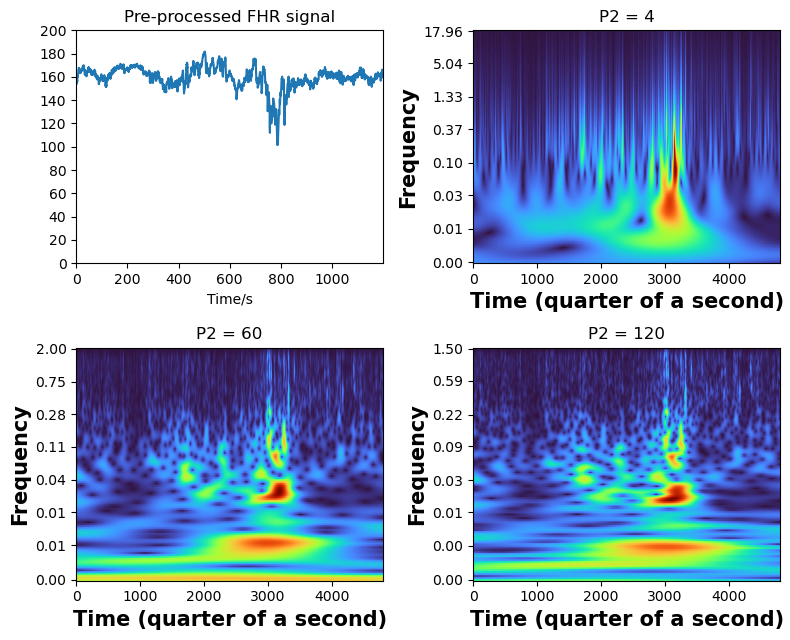

In [16]:
# Initialise plot
fig, ax = plt.subplots(2, 2, figsize=(8, 6.5))

# Plot clean FHR stage 1
ax[0,0].plot(fhr_distress_first['1017'].index/4,
             fhr_distress_first['1017'])
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time/s')
ax[0,0].set_title('Pre-processed FHR signal')
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot CWT with different parameters
daydulo_cwt(fhr_distress_first['1017'], beta=0.75, axes=ax[0,1])
ax[0,1].set_title('P2 = 4')
daydulo_cwt(fhr_distress_first['1017'], beta=20, axes=ax[1,0])
ax[1,0].set_title('P2 = 60')
daydulo_cwt(fhr_distress_first['1017'], beta=40, axes=ax[1,1])
ax[1,1].set_title('P2 = 120')

plt.tight_layout()
plt.show()

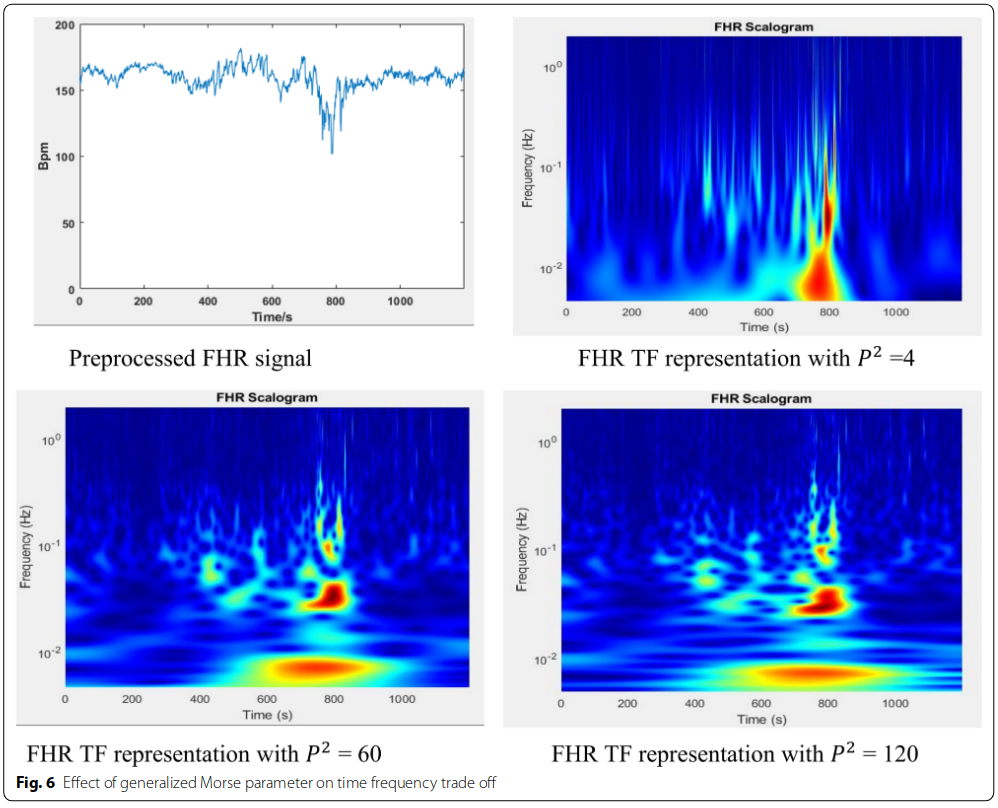

In [17]:
Image('images/daydulo_figure6.png')

## Identify appropriate file paths

### Method in Daydulo et al. 2022

When saving these images, we need to save by class and how dataset will be used. tf.keras.utils.image_dataset_from_directory() will look for the class folders within a main directory, and allows you to designate a proportion for validation.

In Daydulo et al. 2022, data split training : validation (monitor performance and fine tune hyperparameters during training) : test (evaluate model performance) was 80 : 10 : 10. They state then that there were:
* 156 test records (88 normal and 68 distressed) = **10%**
* 1400 training records (790 normal and 610 distressed) - from which, 10% of training data from each class was randomly selected for validation
    * For the record, 10% of 1400 is 140 records (9% of all records overall)
    * The remaining 90% of 1400 is 1260 records (81% of all records overall)
    * **It therefore appears the split is actually 81% training, 9% validation and 10% test (81 : 9 : 10).**

ResNet-50 was trained seperately for first and second stages of labour.

Therefore, to summarise, the records are split as follows:

In [18]:
summary_first = pd.DataFrame({
    'class': ['normal']*3 + ['distress']*3,
    'stage': ['first']*6,
    'set': ['train', 'validation', 'test']*2,
    'records': [ (790*0.9)/2, (790*0.1)/2, 88/2, (610*0.9)/2, (610*0.1)/2, 68/2]
})
summary_second = summary_first.copy()
summary_second['stage'] = 'second'
summary_all = pd.concat([summary_first, summary_second])
summary_all

,class,stage,set,records
0,normal,first,train,355.5
1,normal,first,validation,39.5
2,normal,first,test,44.0
3,distress,first,train,274.5
4,distress,first,validation,30.5
5,distress,first,test,34.0
0,normal,second,train,355.5
1,normal,second,validation,39.5
2,normal,second,test,44.0
3,distress,second,train,274.5


In [19]:
print(f'''
Checking values...
Total records: {summary_all['records'].sum()}
Total test: {summary_all.loc[summary_all['set'] == 'test', 'records'].sum()}
Total train/validation: {summary_all.loc[summary_all['set'] != 'test', 'records'].sum()}
Total validation: {summary_all.loc[summary_all['set'] == 'validation', 'records'].sum()}
Total train: {summary_all.loc[summary_all['set'] == 'train', 'records'].sum()}
''')


Checking values...
Total records: 1556.0
Total test: 156.0
Total train/validation: 1400.0
Total validation: 140.0
Total train: 1260.0



<mark>**Note: It appears that the same records were in the training, test and validation data sets (albeit shifted by 5 minutes)**</mark>

## Split records into sets, apply CWT, and save in appropriate file path

Keras will split training in train and validation, so we just need to create folders for either train/validation or test - hence, train_size = 0.9 (as test size is 10% of all records).

In [20]:
def apply_cwt(dict, file_path):
    '''
    Apply CWT to traces in the provided dictionary, saving files in the
    provided file path.
    Inputs:
    dict - dictionary of FHR signals, where record name will be image name
    file_path - path to folder to store the produced scaleograms
    '''
    for key, value in dict.items():

        # Perform CWT
        fig, ax = plt.subplots()
        daydulo_cwt(value, beta=20, axes=ax)

        # Remove axis and borders, and save as PNG file using record name
        plt.axis('off')
        plt.savefig(f'{file_path}/{key}.png',
                    bbox_inches='tight', pad_inches=0)

        # Close figure else struggles since creating lots in a loop
        plt.close(fig)

In [21]:
def train_test_cwt(dict, path_stage, path_class):
    '''
    Inputs:
    dict - dictionary with FHR (either normal or distressed, and first or second stage)
    path_stage - path to folder with appropriate stage
    path_class - name of folder for appropriate class
    '''
    # Split dictionary into 90% train(/validate) and 10% test
    train, test = train_test_split(
        list(dict.keys()),train_size=0.9, random_state=42)
    train_dict = {key: dict[key] for key in train}
    test_dict = {key: dict[key] for key in test}

    # Create folder paths if they don't yet exist
    train_path = os.path.join(path_stage, paths.train, path_class)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    test_path = os.path.join(path_stage, paths.test, path_class)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # Perform CWT and save the scaleograms
    apply_cwt(train_dict, train_path)
    apply_cwt(test_dict, test_path)

In [22]:
%%time
train_test_cwt(fhr_distress_first, paths.first, paths.distress)

CPU times: user 2min 54s, sys: 7.19 s, total: 3min 1s
Wall time: 2min 8s


In [23]:
%%time
train_test_cwt(fhr_distress_second, paths.second, paths.distress)

CPU times: user 2min 21s, sys: 2.71 s, total: 2min 23s
Wall time: 1min 37s


In [24]:
%%time
train_test_cwt(fhr_normal_first, paths.first, paths.normal)

CPU times: user 3min 34s, sys: 3.68 s, total: 3min 38s
Wall time: 2min 36s


In [25]:
%%time
train_test_cwt(fhr_normal_second, paths.second, paths.normal)

CPU times: user 3min 19s, sys: 3.87 s, total: 3min 22s
Wall time: 2min 21s


## Check file numbers

Look at the number of output files in each directory and check it matches what we expected.

In [26]:
# Initalise counter for total files
N = 0
# Count number of files in all subdirectories of outputs
for dirpath, dirnames, filenames in os.walk('outputs', topdown=True):
    N_c = len(filenames)
    N += N_c
    print(f'Files in {dirpath}, {N_c}')
print(f'Total Files {N}')
print(f'Total Daydulo Files {N - 552 - 552 - 2}')

Files in outputs, 2
Files in outputs/spectograms, 552
Files in outputs/lineplots, 552
Files in outputs/daydulo_cwt_second_stage, 0
Files in outputs/daydulo_cwt_second_stage/test, 0
Files in outputs/daydulo_cwt_second_stage/test/class_1_distressed, 34
Files in outputs/daydulo_cwt_second_stage/test/class_0_normal, 44
Files in outputs/daydulo_cwt_second_stage/train, 0
Files in outputs/daydulo_cwt_second_stage/train/class_1_distressed, 305
Files in outputs/daydulo_cwt_second_stage/train/class_0_normal, 395
Files in outputs/daydulo_cwt_first_stage, 0
Files in outputs/daydulo_cwt_first_stage/test, 0
Files in outputs/daydulo_cwt_first_stage/test/class_1_distressed, 34
Files in outputs/daydulo_cwt_first_stage/test/class_0_normal, 44
Files in outputs/daydulo_cwt_first_stage/train, 0
Files in outputs/daydulo_cwt_first_stage/train/class_1_distressed, 305
Files in outputs/daydulo_cwt_first_stage/train/class_0_normal, 395
Total Files 2662
Total Daydulo Files 1556


Test set has 44 normal and 34 distressed, which is correct

Training set has 395 normal and 305 distressed, which is correct (355.5+39.5=395) (274.5+30.5=305).

In [27]:
summary_all

,class,stage,set,records
0,normal,first,train,355.5
1,normal,first,validation,39.5
2,normal,first,test,44.0
3,distress,first,train,274.5
4,distress,first,validation,30.5
5,distress,first,test,34.0
0,normal,second,train,355.5
1,normal,second,validation,39.5
2,normal,second,test,44.0
3,distress,second,train,274.5
